In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from buck.analysis.basics import ingest_images

# Your existing ingestion
fpath = "C:\\Users\\aaron\\Dropbox\\AI Projects\\buck\\images\\squared\\color\\*.png"
images, ages = ingest_images(fpath)
print(len(images),'images found:')

357 images found:


In [2]:
from buck.analysis.basics import split_data

Xtr_og, ytr_og, Xval, yval, Xte, yte_onehot, ages, l_map = split_data(images, ages)

(228, 288, 288, 3) (57, 288, 288, 3) (72, 288, 288, 3)


In [3]:
from buck.analysis.basics import homogenize_data

augment_multiplier = 20
X_train, y_train, X_test, y_true, label_mapping, num_classes = homogenize_data(Xtr_og, ytr_og, Xte,yte_onehot, l_map, augment_multiplier)

  Class 0 (Age 1.5): 37 → 1120 samples
  Class 1 (Age 2.5): 42 → 1120 samples
  Class 2 (Age 3.5): 46 → 1120 samples
  Class 3 (Age 4.5): 47 → 1120 samples
  Class 4 (Age 5.5): 56 → 1120 samples


In [15]:
!pip install albumentations

   ---------------------------------------- 0.0/39.4 MB ? eta -:--:--
   -------------- ------------------------- 13.9/39.4 MB 67.2 MB/s eta 0:00:01
   ---------------------------------- ----- 33.8/39.4 MB 82.6 MB/s eta 0:00:01
   ---------------------------------------  39.3/39.4 MB 80.7 MB/s eta 0:00:01
   ---------------------------------------- 39.4/39.4 MB 58.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 2.0/2.0 MB 15.5 MB/s eta 0:00:00

   ---------------------------------------- 0/9 [stringzilla]
   ---------------------------------------- 0/9 [stringzilla]
   ---- ----------------------------------- 1/9 [simsimd]
   ------------- -------------------------- 3/9 [pydantic-core]
   ------------- -------------------------- 3/9 [pydantic-core]
   ----------------- ---------------------- 4/9 [opencv-python-headless]



ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'G:\\Dropbox\\AI Projects\\buck\\buck-env\\Lib\\site-packages\\cv2\\cv2.pyd'
Check the permissions.



In [16]:
# Training the model

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.transforms as transforms
import timm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import warnings
import random
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
import albumentations as A
from albumentations.pytorch import ToTensorV2
warnings.filterwarnings('ignore')

class ImprovedDeerDataset(Dataset):
    """
    IMPROVED Dataset with better augmentation and stability
    """
    
    def __init__(self, X, y, transform=None, is_training=True):
        self.X = X
        self.y = y
        self.is_training = is_training
        
        # IMPROVED AUGMENTATION using Albumentations
        if is_training:
            self.transform = A.Compose([
                # Geometric transforms
                A.Resize(384, 384),
                A.RandomRotate90(p=0.5),
                A.Flip(p=0.5),
                A.ShiftScaleRotate(
                    shift_limit=0.1, 
                    scale_limit=0.2, 
                    rotate_limit=15, 
                    p=0.7,
                    border_mode=0
                ),
                
                # Photometric transforms
                A.RandomBrightnessContrast(
                    brightness_limit=0.2, 
                    contrast_limit=0.2, 
                    p=0.6
                ),
                A.HueSaturationValue(
                    hue_shift_limit=10, 
                    sat_shift_limit=20, 
                    val_shift_limit=15, 
                    p=0.5
                ),
                A.GaussNoise(var_limit=(0.0, 0.01), p=0.3),
                A.OneOf([
                    A.MotionBlur(blur_limit=3, p=1.0),
                    A.GaussianBlur(blur_limit=3, p=1.0),
                ], p=0.2),
                
                # Cutout/Erasing
                A.CoarseDropout(
                    max_holes=8, 
                    max_height=32, 
                    max_width=32, 
                    p=0.3
                ),
                
                # Normalize to 0-1
                A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
                ToTensorV2()
            ])
        else:
            # Validation - minimal transforms
            self.transform = A.Compose([
                A.Resize(384, 384),
                A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
                ToTensorV2()
            ])
        
        print(f"Dataset: {len(X)} samples, training={is_training}")
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx].astype(np.float32)
        label = self.y[idx]
        
        # Apply augmentation
        if self.transform:
            augmented = self.transform(image=image)
            image_tensor = augmented['image']
        else:
            # Fallback
            image_tensor = torch.FloatTensor(image).permute(2, 0, 1)
        
        return image_tensor, torch.LongTensor([label]).squeeze()

class ImprovedDeerAgeEfficientNet:
    """
    IMPROVED EfficientNet with better training stability and performance
    """
    
    def __init__(self, num_classes=5):
        self.num_classes = num_classes
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        # Create improved model
        self.create_improved_model()
        
    def create_improved_model(self):
        """
        Create IMPROVED EfficientNet model
        """
        # Try EfficientNet-B3 for better speed/accuracy balance
        self.model = timm.create_model(
            'efficientnet_b3',  # Changed from B4 to B3 for stability
            pretrained=True,
            num_classes=self.num_classes,
            drop_rate=0.4,      # Increased dropout
            drop_path_rate=0.3  # Increased stochastic depth
        )
        
        # IMPROVED classifier with better regularization
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=0.3),
            nn.Linear(256, self.num_classes)
        )
        
        self.model = self.model.to(self.device)
        
        # Count parameters
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print(f"✅ EfficientNet-B3 created:")
        print(f"   Total parameters: {total_params:,}")
        print(f"   Trainable parameters: {trainable_params:,}")
    
    def prepare_improved_data_loaders(self, X_train, y_train, X_val, y_val, batch_size=32):
        """
        Create IMPROVED data loaders with better augmentation
        """
        print("🔄 Preparing IMPROVED data loaders...")
        
        # Create datasets with improved augmentation
        train_dataset = ImprovedDeerDataset(X_train, y_train, is_training=True)
        val_dataset = ImprovedDeerDataset(X_val, y_val, is_training=False)
        
        # IMPROVED data loaders with better settings
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=0,
            pin_memory=True,
            drop_last=True  # Consistent batch sizes
        )
        val_loader = DataLoader(
            val_dataset, 
            batch_size=batch_size, 
            shuffle=False, 
            num_workers=0,
            pin_memory=True
        )
        
        print(f"✅ Training loader: {len(train_loader)} batches (batch size: {batch_size})")
        print(f"✅ Validation loader: {len(val_loader)} batches")
        
        return train_loader, val_loader
    
    def train_improved_model(self, train_loader, val_loader, epochs=100, learning_rate=3e-4):
        """
        IMPROVED training with better stability and performance
        """
        print(f"🚀 Starting IMPROVED training for {epochs} epochs...")
        
        # IMPROVED OPTIMIZER with better settings
        optimizer = optim.AdamW(
            self.model.parameters(), 
            lr=learning_rate, 
            weight_decay=0.02,  # Increased weight decay
            betas=(0.9, 0.999),
            eps=1e-8
        )
        
        # IMPROVED SCHEDULER with warm restarts
        scheduler = CosineAnnealingWarmRestarts(
            optimizer, 
            T_0=20,      # Restart every 20 epochs
            T_mult=2,    # Double the period after each restart
            eta_min=1e-7 # Minimum learning rate
        )
        
        # LABEL SMOOTHING for better generalization
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        
        # Training history
        history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'learning_rate': []
        }
        
        best_val_acc = 0.0
        patience = 25  # Increased patience
        patience_counter = 0
        
        # GRADIENT ACCUMULATION for larger effective batch size
        accumulation_steps = 2
        
        print(f"📋 Training Configuration:")
        print(f"   Optimizer: AdamW (lr={learning_rate}, weight_decay=0.02)")
        print(f"   Scheduler: CosineAnnealingWarmRestarts (T_0=20)")
        print(f"   Label smoothing: 0.1")
        print(f"   Gradient accumulation: {accumulation_steps} steps")
        print(f"   Patience: {patience} epochs")
        
        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            optimizer.zero_grad()
            
            for batch_idx, (images, labels) in enumerate(train_loader):
                images, labels = images.to(self.device), labels.to(self.device)
                
                # Forward pass
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                
                # Scale loss for accumulation
                loss = loss / accumulation_steps
                loss.backward()
                
                # Gradient accumulation
                if ((batch_idx + 1) % accumulation_steps == 0) or (batch_idx + 1 == len(train_loader)):
                    # Gradient clipping
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                    optimizer.step()
                    optimizer.zero_grad()
                
                # Statistics
                train_loss += loss.item() * accumulation_steps  # Unscale for logging
                _, predicted = outputs.max(1)
                train_total += labels.size(0)
                train_correct += predicted.eq(labels).sum().item()
                
                # Progress update
                if batch_idx % 10 == 0:
                    current_acc = 100. * train_correct / train_total
                    current_lr = optimizer.param_groups[0]['lr']
                    print(f'Epoch {epoch+1}/{epochs} | Batch {batch_idx}/{len(train_loader)} | '
                          f'Loss: {loss.item()*accumulation_steps:.4f} | Acc: {current_acc:.1f}% | LR: {current_lr:.2e}')
            
            # Validation phase
            val_loss, val_acc = self._validate_improved(val_loader, criterion)
            
            # Update scheduler
            scheduler.step()
            
            # Update history
            train_acc = 100. * train_correct / train_total
            train_loss = train_loss / len(train_loader)
            current_lr = optimizer.param_groups[0]['lr']
            
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            history['learning_rate'].append(current_lr)
            
            # Print epoch results
            print(f'\n📊 Epoch {epoch+1}/{epochs} Results:')
            print(f'   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
            print(f'   Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
            print(f'   Learning Rate: {current_lr:.2e}')
            
            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(self.model.state_dict(), 'best_deer_efficientnet_improved.pth')
                patience_counter = 0
                print(f'   🎯 NEW BEST MODEL! Validation Accuracy: {val_acc:.2f}%')
            else:
                patience_counter += 1
                print(f'   Patience: {patience_counter}/{patience}')
            
            # Early stopping
            if patience_counter >= patience:
                print(f'\n⏰ Early stopping after {epoch+1} epochs')
                break
            
            print('-' * 80)
        
        # Load best model
        self.model.load_state_dict(torch.load('best_deer_efficientnet_improved.pth'))
        print(f'\n🏆 IMPROVED training completed!')
        print(f'   Best validation accuracy: {best_val_acc:.2f}%')
        print(f'   Target: 70%+ test accuracy')
        
        return history, best_val_acc
    
    def _validate_improved(self, val_loader, criterion):
        """
        IMPROVED validation function
        """
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        
        return val_loss, val_acc
    
    def plot_improved_training_history(self, history):
        """
        Plot IMPROVED training curves with learning rate
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss curves
        axes[0,0].plot(history['train_loss'], label='Training Loss', linewidth=2)
        axes[0,0].plot(history['val_loss'], label='Validation Loss', linewidth=2)
        axes[0,0].set_title('Model Loss', fontsize=14)
        axes[0,0].set_xlabel('Epoch')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Accuracy curves
        axes[0,1].plot(history['train_acc'], label='Training Accuracy', linewidth=2)
        axes[0,1].plot(history['val_acc'], label='Validation Accuracy', linewidth=2)
        axes[0,1].axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Target 70%')
        axes[0,1].set_title('Model Accuracy', fontsize=14)
        axes[0,1].set_xlabel('Epoch')
        axes[0,1].set_ylabel('Accuracy (%)')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # Learning rate
        axes[1,0].plot(history['learning_rate'], linewidth=2, color='green')
        axes[1,0].set_title('Learning Rate Schedule', fontsize=14)
        axes[1,0].set_xlabel('Epoch')
        axes[1,0].set_ylabel('Learning Rate')
        axes[1,0].set_yscale('log')
        axes[1,0].grid(True, alpha=0.3)
        
        # Validation accuracy smoothed
        if len(history['val_acc']) > 10:
            # Simple moving average
            window = min(5, len(history['val_acc'])//5)
            val_acc_smooth = np.convolve(history['val_acc'], np.ones(window)/window, mode='valid')
            axes[1,1].plot(history['val_acc'], alpha=0.3, label='Raw Val Acc')
            axes[1,1].plot(range(window-1, len(history['val_acc'])), val_acc_smooth, 
                          linewidth=2, label='Smoothed Val Acc')
            axes[1,1].axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Target 70%')
            axes[1,1].set_title('Smoothed Validation Accuracy', fontsize=14)
            axes[1,1].set_xlabel('Epoch')
            axes[1,1].set_ylabel('Accuracy (%)')
            axes[1,1].legend()
            axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print final stats
        final_val_acc = max(history['val_acc'])
        print(f"📈 IMPROVED Training Summary:")
        print(f"   Best Validation Accuracy: {final_val_acc:.2f}%")
        print(f"   Target for publication: 70%+")
        if final_val_acc >= 70:
            print(f"   🎉 TARGET ACHIEVED! Ready for publication!")
        else:
            print(f"   📈 Progress: {final_val_acc:.1f}% / 70% ({final_val_acc-70:+.1f}%)")

def run_improved_training(X_train, y_train, X_val, y_val, X_test, y_test, label_mapping):
    """
    Run IMPROVED training pipeline for 70%+ test accuracy
    """
    print("🦌 IMPROVED DEER AGE CLASSIFICATION TRAINING")
    print("=" * 70)
    print("🎯 TARGET: 70%+ test accuracy for publication")
    print("🔧 IMPROVEMENTS:")
    print("   ✅ Better data augmentation (Albumentations)")
    print("   ✅ EfficientNet-B3 for stability")
    print("   ✅ Improved classifier with BatchNorm")
    print("   ✅ Label smoothing (0.1)")
    print("   ✅ CosineAnnealingWarmRestarts scheduler")
    print("   ✅ Gradient accumulation")
    print("   ✅ Better regularization")
    print("   ✅ Increased patience (25 epochs)")
    print("=" * 70)
    
    # Convert one-hot to class indices if needed
    if len(y_train.shape) == 2:
        print(f"Converting y_train from one-hot {y_train.shape} to class indices")
        y_train = np.argmax(y_train, axis=1)
    
    if len(y_val.shape) == 2:
        print(f"Converting y_val from one-hot {y_val.shape} to class indices") 
        y_val = np.argmax(y_val, axis=1)
    
    if len(y_test.shape) == 2:
        print(f"Converting y_test from one-hot {y_test.shape} to class indices")
        y_test = np.argmax(y_test, axis=1)
    
    # Initialize IMPROVED classifier
    classifier = ImprovedDeerAgeEfficientNet(num_classes=len(label_mapping))
    
    # Prepare IMPROVED data loaders
    train_loader, val_loader = classifier.prepare_improved_data_loaders(
        X_train, y_train, X_val, y_val, batch_size=32  # Larger batch size
    )
    
    # Train IMPROVED model
    history, best_val_acc = classifier.train_improved_model(
        train_loader, val_loader, epochs=100, learning_rate=3e-4
    )
    
    # Plot IMPROVED training history
    classifier.plot_improved_training_history(history)
    
    print(f"\n🎯 FINAL RESULT: Best validation accuracy = {best_val_acc:.2f}%")
    
    return classifier, history, best_val_acc

# Run the IMPROVED training
classifier_improved, history_improved, best_val_acc = run_improved_training(X_train, y_train, Xval, yval, X_test, y_true, label_mapping)

ModuleNotFoundError: No module named 'albumentations'

In [4]:
# Imaging where the model is looking

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from matplotlib.colors import LinearSegmentedColormap
import timm

class GradCAM:
    """
    Grad-CAM implementation for visualizing what features the model focuses on
    """
    
    def __init__(self, model, target_layer_name):
        self.model = model
        self.target_layer_name = target_layer_name
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self.register_hooks()
    
    def register_hooks(self):
        """Register forward and backward hooks to capture gradients and activations"""
        
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        
        def forward_hook(module, input, output):
            self.activations = output
        
        # Find the target layer
        target_layer = None
        for name, module in self.model.named_modules():
            if name == self.target_layer_name:
                target_layer = module
                break
        
        if target_layer is None:
            raise ValueError(f"Layer {self.target_layer_name} not found in model")
        
        # Register hooks
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)
    
    def generate_cam(self, image_tensor, class_idx=None):
        """
        Generate Grad-CAM for a given image
        
        Args:
            image_tensor: Input image tensor (1, 3, H, W)
            class_idx: Target class index (if None, uses predicted class)
        
        Returns:
            cam: Grad-CAM heatmap
            prediction: Model prediction
        """
        # Forward pass
        self.model.eval()
        output = self.model(image_tensor)
        
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        
        # Backward pass
        self.model.zero_grad()
        target = output[0][class_idx]
        target.backward()
        
        # Get gradients and activations
        gradients = self.gradients[0]  # (C, H, W)
        activations = self.activations[0]  # (C, H, W)
        
        # Calculate weights (global average pooling of gradients)
        weights = torch.mean(gradients, dim=(1, 2))  # (C,)
        
        # Generate CAM
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        # Apply ReLU and normalize
        cam = F.relu(cam)
        cam = cam / cam.max() if cam.max() > 0 else cam
        
        return cam.detach().cpu().numpy(), output.detach().cpu().numpy()

def load_trained_model(model_path='best_deer_efficientnet.pth', num_classes=5):
    """
    Load the saved deer age classification model
    
    Args:
        model_path: Path to saved model weights
        num_classes: Number of age classes
    
    Returns:
        model: Loaded model ready for inference
    """
    print(f"🔄 Loading trained model from {model_path}...")
    
    # Recreate the model architecture (same as in training)
    model = timm.create_model(
        'efficientnet_b4',
        pretrained=False,  # Don't download pretrained weights
        num_classes=num_classes,
        drop_rate=0.3,
        drop_path_rate=0.2
    )
    
    # Replace classifier (same as in training)
    in_features = model.classifier.in_features
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.4, inplace=True),
        torch.nn.Linear(in_features, num_classes)
    )
    
    # Load the saved weights
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    
    print(f"✅ Model loaded successfully on {device}")
    return model

def visualize_deer_features(model, X_test, y_test, label_mapping, num_images=6):
    """
    Visualize which features the model focuses on for deer age prediction
    
    Args:
        model: Loaded trained model
        X_test: Test images
        y_test: True labels (as class indices, not one-hot)
        label_mapping: Age to class mapping
        num_images: Number of images to visualize
    """
    
    # Convert one-hot to class indices if needed
    if len(y_test.shape) == 2:
        y_test = np.argmax(y_test, axis=1)
    
    # Create reverse mapping
    class_to_age = {v: k for k, v in label_mapping.items()}
    
    # Initialize Grad-CAM (target the last convolutional layer)
    grad_cam = GradCAM(model, target_layer_name='features.8.2.block.2')
    
    # Select random test images
    indices = np.random.choice(len(X_test), num_images, replace=False)
    
    # Create custom colormap for heatmap
    colors = ['blue', 'cyan', 'yellow', 'orange', 'red']
    n_bins = 256
    cmap = LinearSegmentedColormap.from_list('grad_cam', colors, N=n_bins)
    
    # Create subplot
    fig, axes = plt.subplots(2, num_images, figsize=(20, 8))
    if num_images == 1:
        axes = axes.reshape(2, 1)
    
    device = next(model.parameters()).device
    
    for i, idx in enumerate(indices):
        # Prepare image
        original_image = X_test[idx]
        true_age = class_to_age[y_test[idx]]
        
        # Convert to tensor and add batch dimension
        image_tensor = torch.FloatTensor(original_image).permute(2, 0, 1).unsqueeze(0)
        image_tensor = image_tensor.to(device)
        
        # Resize to model input size (384x384 for EfficientNet-B4)
        image_tensor = F.interpolate(image_tensor, size=(384, 384), mode='bilinear', align_corners=False)
        
        # Normalize (ImageNet normalization)
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
        image_tensor = (image_tensor - mean) / std
        
        # Generate Grad-CAM
        cam, prediction = grad_cam.generate_cam(image_tensor)
        predicted_class = np.argmax(prediction[0])
        predicted_age = class_to_age[predicted_class]
        confidence = F.softmax(torch.tensor(prediction[0]), dim=0)[predicted_class].item()
        
        # Resize CAM to original image size
        cam_resized = cv2.resize(cam, (original_image.shape[1], original_image.shape[0]))
        
        # Display original image
        axes[0, i].imshow(original_image)
        axes[0, i].set_title(f'Original Image\nTrue Age: {true_age} years', fontsize=12)
        axes[0, i].axis('off')
        
        # Display Grad-CAM overlay
        axes[1, i].imshow(original_image)
        axes[1, i].imshow(cam_resized, cmap=cmap, alpha=0.5, vmin=0, vmax=1)
        axes[1, i].set_title(f'Predicted: {predicted_age} years\nConfidence: {confidence:.2%}', fontsize=12)
        axes[1, i].axis('off')
        
        print(f"Image {i+1}: True={true_age}y, Predicted={predicted_age}y, Confidence={confidence:.1%}")
    
    plt.suptitle('Deer Age Classification: Feature Importance Visualization', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()
    
    # Create a colorbar legend
    fig, ax = plt.subplots(figsize=(8, 1))
    gradient = np.linspace(0, 1, 256).reshape(1, -1)
    ax.imshow(gradient, aspect='auto', cmap=cmap)
    ax.set_xlim(0, 256)
    ax.set_yticks([])
    ax.set_xticks([0, 64, 128, 192, 256])
    ax.set_xticklabels(['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'])
    ax.set_xlabel('Feature Importance for Age Prediction')
    ax.set_title('Grad-CAM Heatmap Legend: Red = High Importance, Blue = Low Importance')
    plt.tight_layout()
    plt.show()

def analyze_feature_patterns(model, X_test, y_test, label_mapping, samples_per_age=3):
    """
    Analyze what features the model focuses on for each age group
    """
    # Convert one-hot to class indices if needed
    if len(y_test.shape) == 2:
        y_test = np.argmax(y_test, axis=1)
    
    class_to_age = {v: k for k, v in label_mapping.items()}
    grad_cam = GradCAM(model, target_layer_name='features.8.2.block.2')
    
    print("🔍 ANALYZING FEATURE PATTERNS BY AGE GROUP")
    print("=" * 60)
    
    # Group images by age
    age_groups = {}
    for i, label in enumerate(y_test):
        age = class_to_age[label]
        if age not in age_groups:
            age_groups[age] = []
        age_groups[age].append(i)
    
    device = next(model.parameters()).device
    
    for age in sorted(age_groups.keys()):
        print(f"\n📊 AGE GROUP: {age} YEARS")
        print("-" * 30)
        
        # Sample images from this age group
        indices = np.random.choice(age_groups[age], min(samples_per_age, len(age_groups[age])), replace=False)
        
        cam_averages = []
        
        for idx in indices:
            # Prepare image
            original_image = X_test[idx]
            image_tensor = torch.FloatTensor(original_image).permute(2, 0, 1).unsqueeze(0)
            image_tensor = image_tensor.to(device)
            image_tensor = F.interpolate(image_tensor, size=(384, 384), mode='bilinear', align_corners=False)
            
            # Normalize
            mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
            std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
            image_tensor = (image_tensor - mean) / std
            
            # Generate CAM
            cam, prediction = grad_cam.generate_cam(image_tensor)
            predicted_class = np.argmax(prediction[0])
            predicted_age = class_to_age[predicted_class]
            confidence = F.softmax(torch.tensor(prediction[0]), dim=0)[predicted_class].item()
            
            cam_averages.append(cam)
            
            print(f"   Sample {len(cam_averages)}: Predicted {predicted_age}y (confidence: {confidence:.1%})")
        
        # Calculate average attention pattern for this age group
        avg_cam = np.mean(cam_averages, axis=0)
        
        # Analyze where the model focuses
        height, width = avg_cam.shape
        
        # Divide image into regions and calculate average attention
        regions = {
            'Top (Head/Antlers)': avg_cam[:height//3, :].mean(),
            'Middle (Body)': avg_cam[height//3:2*height//3, :].mean(), 
            'Bottom (Legs)': avg_cam[2*height//3:, :].mean(),
            'Left Side': avg_cam[:, :width//2].mean(),
            'Right Side': avg_cam[:, width//2:].mean(),
            'Center': avg_cam[height//4:3*height//4, width//4:3*width//4].mean()
        }
        
        print(f"   🎯 Key focus areas:")
        for region, attention in sorted(regions.items(), key=lambda x: x[1], reverse=True):
            print(f"      {region}: {attention:.3f}")

def run_gradcam_analysis(X_test, y_test, label_mapping, model_path='best_deer_efficientnet.pth'):
    """
    Complete pipeline to load model and run Grad-CAM analysis
    
    Args:
        X_test: Test images
        y_test: True labels
        label_mapping: Age to class mapping dict
        model_path: Path to saved model weights
    """
    print("🦌 DEER AGE CLASSIFICATION: GRAD-CAM FEATURE ANALYSIS")
    print("=" * 70)
    
    # Load the trained model
    model = load_trained_model(model_path, num_classes=len(label_mapping))
    
    # Run Grad-CAM visualization
    print("\n📸 Generating Grad-CAM visualizations...")
    visualize_deer_features(model, X_test, y_test, label_mapping, num_images=6)
    
    # Analyze patterns by age group
    print("\n🔍 Analyzing feature patterns by age group...")
    analyze_feature_patterns(model, X_test, y_test, label_mapping, samples_per_age=3)
    
    print("\n✅ Grad-CAM analysis complete!")
    print("\nKey insights to look for:")
    print("🔍 Young deer (1.5-2.5y): Model may focus on body size, facial features")
    print("🔍 Middle-aged (3.5y): Model may focus on antler development, body mass")  
    print("🔍 Older deer (4.5-5.5y): Model may focus on antler size, body structure")
    
    return model

# USAGE: Run this after training to analyze your saved model
model = run_gradcam_analysis(X_test, y_true, label_mapping, 'best_deer_efficientnet.pth')


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "G:\Dropbox\AI Projects\buck\buck-env\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "G:\Dropbox\AI Projects\buck\buck-env\Lib\site-packages\traitlets\config\application.py", line 10

🦌 DEER AGE CLASSIFICATION: GRAD-CAM FEATURE ANALYSIS
🔄 Loading trained model from best_deer_efficientnet.pth...
✅ Model loaded successfully on cuda

📸 Generating Grad-CAM visualizations...


ValueError: Layer features.8.2.block.2 not found in model

🦌 DEER AGE CLASSIFICATION: CORRECTED MODEL EVALUATION
🔧 Using CORRECT preprocessing (no ImageNet normalization)
   This matches what your model was actually trained on!
🔄 Loading trained model from best_deer_efficientnet.pth...
✅ Model loaded successfully on cuda
🎯 EVALUATING MODEL ON TEST SET - CORRECTED PREPROCESSING
Test set size: 72 images
Number of classes: 5
Age mapping: {np.float64(1.5): 0, np.float64(2.5): 1, np.float64(3.5): 2, np.float64(4.5): 3, np.float64(5.5): 4}
Class to age: {0: np.float64(1.5), 1: np.float64(2.5), 2: np.float64(3.5), 3: np.float64(4.5), 4: np.float64(5.5)}

🔄 Making predictions with CORRECT preprocessing...
   ✅ Using raw 0-1 normalized pixels (NO ImageNet normalization)
   Processed 16/72 images...
✅ Predictions complete!

📊 CALCULATING METRICS
------------------------------
🎯 Test Accuracy: 0.5556 (55.56%)
📈 F1 Score (Macro): 0.5487
📈 F1 Score (Weighted): 0.5449
📈 F1 Score (Micro): 0.5556

📋 DETAILED CLASSIFICATION REPORT:
              precision    r

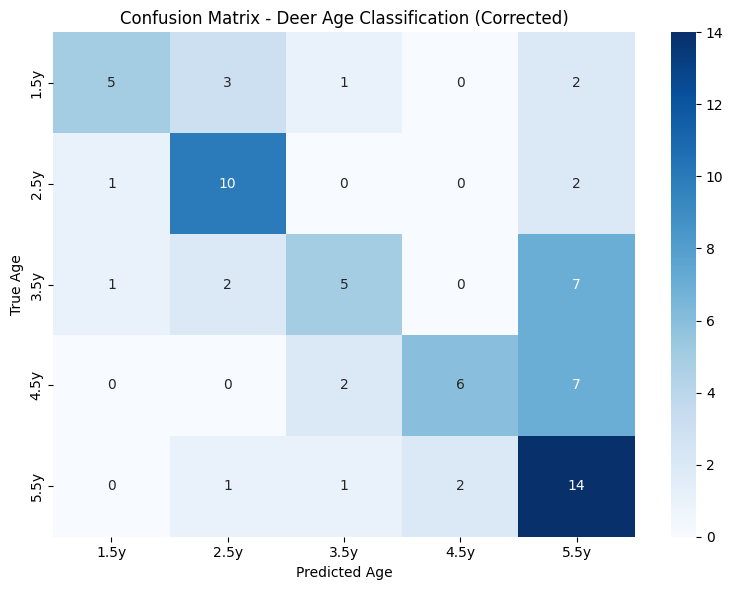


🦌 AGE-SPECIFIC ANALYSIS:
------------------------------
Age 1.5 years (11 samples):
   Accuracy: 0.455 (45.5%)
   Precision: 0.714
   Recall: 0.455
   F1-Score: 0.556
Age 2.5 years (13 samples):
   Accuracy: 0.769 (76.9%)
   Precision: 0.625
   Recall: 0.769
   F1-Score: 0.690
Age 3.5 years (15 samples):
   Accuracy: 0.333 (33.3%)
   Precision: 0.556
   Recall: 0.333
   F1-Score: 0.417
Age 4.5 years (15 samples):
   Accuracy: 0.400 (40.0%)
   Precision: 0.750
   Recall: 0.400
   F1-Score: 0.522
Age 5.5 years (18 samples):
   Accuracy: 0.778 (77.8%)
   Precision: 0.438
   Recall: 0.778
   F1-Score: 0.560

🎯 TOLERANCE-BASED ACCURACY:
------------------------------
Exact age accuracy: 0.556 (55.6%)
Within ±1 year accuracy: 0.792 (79.2%)

📊 PREDICTION DISTRIBUTION:
------------------------------
   Predicted 1.5 years: 7 times (9.7%)
   Predicted 2.5 years: 16 times (22.2%)
   Predicted 3.5 years: 9 times (12.5%)
   Predicted 4.5 years: 8 times (11.1%)
   Predicted 5.5 years: 32 times (44

In [13]:
# Corrected model test
import torch
import torch.nn.functional as F
import numpy as np
import timm
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def load_trained_model(model_path='best_deer_efficientnet.pth', num_classes=5):
    """
    Load the saved deer age classification model
    """
    print(f"🔄 Loading trained model from {model_path}...")
    
    # Recreate the model architecture (same as in training)
    model = timm.create_model(
        'efficientnet_b4',
        pretrained=False,  # Don't download pretrained weights
        num_classes=num_classes,
        drop_rate=0.3,
        drop_path_rate=0.2
    )
    
    # Replace classifier (same as in training)
    in_features = model.classifier.in_features
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.4, inplace=True),
        torch.nn.Linear(in_features, num_classes)
    )
    
    # Load the saved weights
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    
    print(f"✅ Model loaded successfully on {device}")
    return model

def evaluate_model_correct_preprocessing(model, X_test, y_test, label_mapping):
    """
    Evaluate model with CORRECT preprocessing (no ImageNet normalization)
    """
    print("🎯 EVALUATING MODEL ON TEST SET - CORRECTED PREPROCESSING")
    print("=" * 60)
    
    # Convert one-hot to class indices if needed
    if len(y_test.shape) == 2:
        print(f"Converting one-hot labels {y_test.shape} to class indices...")
        y_test = np.argmax(y_test, axis=1)
        print(f"✅ Labels now: {y_test.shape}")
    
    # Create reverse mapping
    class_to_age = {v: k for k, v in label_mapping.items()}
    
    print(f"Test set size: {len(X_test)} images")
    print(f"Number of classes: {len(label_mapping)}")
    print(f"Age mapping: {label_mapping}")
    print(f"Class to age: {class_to_age}")
    
    # Get device
    device = next(model.parameters()).device
    
    # Make predictions
    model.eval()
    all_predictions = []
    all_probabilities = []
    
    print("\n🔄 Making predictions with CORRECT preprocessing...")
    print("   ✅ Using raw 0-1 normalized pixels (NO ImageNet normalization)")
    
    with torch.no_grad():
        # Process in batches to avoid memory issues
        batch_size = 16
        for i in range(0, len(X_test), batch_size):
            batch_end = min(i + batch_size, len(X_test))
            batch_images = X_test[i:batch_end]
            
            # Convert to tensor - same as training
            batch_tensor = torch.FloatTensor(batch_images).permute(0, 3, 1, 2).to(device)
            
            # Resize to model input size (384x384 for EfficientNet-B4)
            batch_tensor = F.interpolate(batch_tensor, size=(384, 384), mode='bilinear', align_corners=False)
            
            # ✅ NO IMAGENET NORMALIZATION - just use raw 0-1 pixel values
            # This matches what your model was actually trained on!
            
            # Get predictions
            logits = model(batch_tensor)
            probabilities = F.softmax(logits, dim=1)
            predicted_classes = torch.argmax(logits, dim=1)
            
            # Convert to Python lists
            all_predictions.extend(predicted_classes.tolist())
            all_probabilities.extend(probabilities.tolist())
            
            if i % (batch_size * 5) == 0:
                print(f"   Processed {batch_end}/{len(X_test)} images...")
    
    # Convert to numpy arrays
    y_pred = np.array(all_predictions)
    y_proba = np.array(all_probabilities)
    
    print(f"✅ Predictions complete!")
    
    # Calculate metrics
    print("\n📊 CALCULATING METRICS")
    print("-" * 30)
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"🎯 Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # F1 Scores
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    
    print(f"📈 F1 Score (Macro): {f1_macro:.4f}")
    print(f"📈 F1 Score (Weighted): {f1_weighted:.4f}")
    print(f"📈 F1 Score (Micro): {f1_micro:.4f}")
    
    # Per-class metrics
    print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
    age_labels = [class_to_age[i] for i in range(len(label_mapping))]
    target_names = [f"{age} years" for age in age_labels]
    
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    # Confusion Matrix
    print(f"\n🔍 CONFUSION MATRIX:")
    cm = confusion_matrix(y_test, y_pred)
    
    # Print confusion matrix
    print("Predicted →")
    print("True ↓   ", "  ".join([f"{age:4.1f}" for age in age_labels]))
    for i, age in enumerate(age_labels):
        row_str = " ".join([f"{cm[i][j]:4d}" for j in range(len(age_labels))])
        print(f"{age:4.1f}     {row_str}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[f"{age}y" for age in age_labels],
                yticklabels=[f"{age}y" for age in age_labels])
    plt.title('Confusion Matrix - Deer Age Classification (Corrected)')
    plt.xlabel('Predicted Age')
    plt.ylabel('True Age')
    plt.tight_layout()
    plt.show()
    
    # Age-based accuracy analysis
    print(f"\n🦌 AGE-SPECIFIC ANALYSIS:")
    print("-" * 30)
    
    for class_idx in range(len(label_mapping)):
        age = class_to_age[class_idx]
        
        # Get indices for this age class
        true_class_mask = (y_test == class_idx)
        if np.sum(true_class_mask) > 0:
            class_accuracy = np.sum((y_test == class_idx) & (y_pred == class_idx)) / np.sum(true_class_mask)
            class_count = np.sum(true_class_mask)
            class_f1 = report[f"{age} years"]['f1-score']
            class_precision = report[f"{age} years"]['precision']
            class_recall = report[f"{age} years"]['recall']
            
            print(f"Age {age} years ({class_count} samples):")
            print(f"   Accuracy: {class_accuracy:.3f} ({class_accuracy*100:.1f}%)")
            print(f"   Precision: {class_precision:.3f}")
            print(f"   Recall: {class_recall:.3f}")
            print(f"   F1-Score: {class_f1:.3f}")
    
    # Tolerance-based accuracy
    print(f"\n🎯 TOLERANCE-BASED ACCURACY:")
    print("-" * 30)
    
    # Convert class indices back to actual ages
    y_test_ages = [class_to_age[idx] for idx in y_test]
    y_pred_ages = [class_to_age[idx] for idx in y_pred]
    
    exact_matches = sum(1 for true, pred in zip(y_test_ages, y_pred_ages) if true == pred)
    within_1_year = sum(1 for true, pred in zip(y_test_ages, y_pred_ages) if abs(true - pred) <= 1.0)
    
    exact_accuracy = exact_matches / len(y_test_ages)
    tolerance_accuracy = within_1_year / len(y_test_ages)
    
    print(f"Exact age accuracy: {exact_accuracy:.3f} ({exact_accuracy*100:.1f}%)")
    print(f"Within ±1 year accuracy: {tolerance_accuracy:.3f} ({tolerance_accuracy*100:.1f}%)")
    
    # Show prediction distribution
    print(f"\n📊 PREDICTION DISTRIBUTION:")
    print("-" * 30)
    pred_counts = {}
    for pred in y_pred:
        age = class_to_age[pred]
        pred_counts[age] = pred_counts.get(age, 0) + 1
    
    for age in sorted(pred_counts.keys()):
        count = pred_counts[age]
        print(f"   Predicted {age} years: {count} times ({count/len(y_pred)*100:.1f}%)")
    
    # Show some example predictions
    print(f"\n🔍 SAMPLE PREDICTIONS:")
    print("-" * 30)
    for i in range(min(15, len(y_test))):
        true_age = y_test_ages[i]
        pred_age = y_pred_ages[i]
        confidence = max(y_proba[i])
        status = "✅" if true_age == pred_age else "❌"
        print(f"{status} Sample {i+1}: True {true_age}y → Predicted {pred_age}y (confidence: {confidence:.2%})")
    
    # Return results
    results = {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'f1_micro': f1_micro,
        'confusion_matrix': cm,
        'classification_report': report,
        'predictions': y_pred,
        'probabilities': y_proba,
        'exact_accuracy': exact_accuracy,
        'tolerance_accuracy': tolerance_accuracy
    }
    
    return results

def run_corrected_evaluation(X_test, y_test, label_mapping, model_path='best_deer_efficientnet.pth'):
    """
    Complete corrected evaluation pipeline
    """
    print("🦌 DEER AGE CLASSIFICATION: CORRECTED MODEL EVALUATION")
    print("=" * 70)
    print("🔧 Using CORRECT preprocessing (no ImageNet normalization)")
    print("   This matches what your model was actually trained on!")
    
    # Load the trained model
    model = load_trained_model(model_path, num_classes=len(label_mapping))
    
    # Evaluate the model with correct preprocessing
    results = evaluate_model_correct_preprocessing(model, X_test, y_test, label_mapping)
    
    print("\n✅ CORRECTED EVALUATION COMPLETE!")
    print(f"📊 Final Results Summary:")
    print(f"   Test Accuracy: {results['accuracy']:.3f} ({results['accuracy']*100:.1f}%)")
    print(f"   F1 Score (Macro): {results['f1_macro']:.3f}")
    print(f"   F1 Score (Weighted): {results['f1_weighted']:.3f}")
    print(f"   Exact Age Accuracy: {results['exact_accuracy']:.3f} ({results['exact_accuracy']*100:.1f}%)")
    print(f"   Within ±1 Year Accuracy: {results['tolerance_accuracy']:.3f} ({results['tolerance_accuracy']*100:.1f}%)")
    
    return results

# Run the CORRECTED evaluation
results = run_corrected_evaluation(X_test, y_true, label_mapping, 'best_deer_efficientnet.pth')

In [ ]:
from buck.classifiers.autotune import optimize_all

optimize_all(X_train, y_train, X_test, y_true, cycles=2)

In [8]:
import numpy as np